## Êï∞ÊçÆÂíåÂåÖÂØºÂÖ•

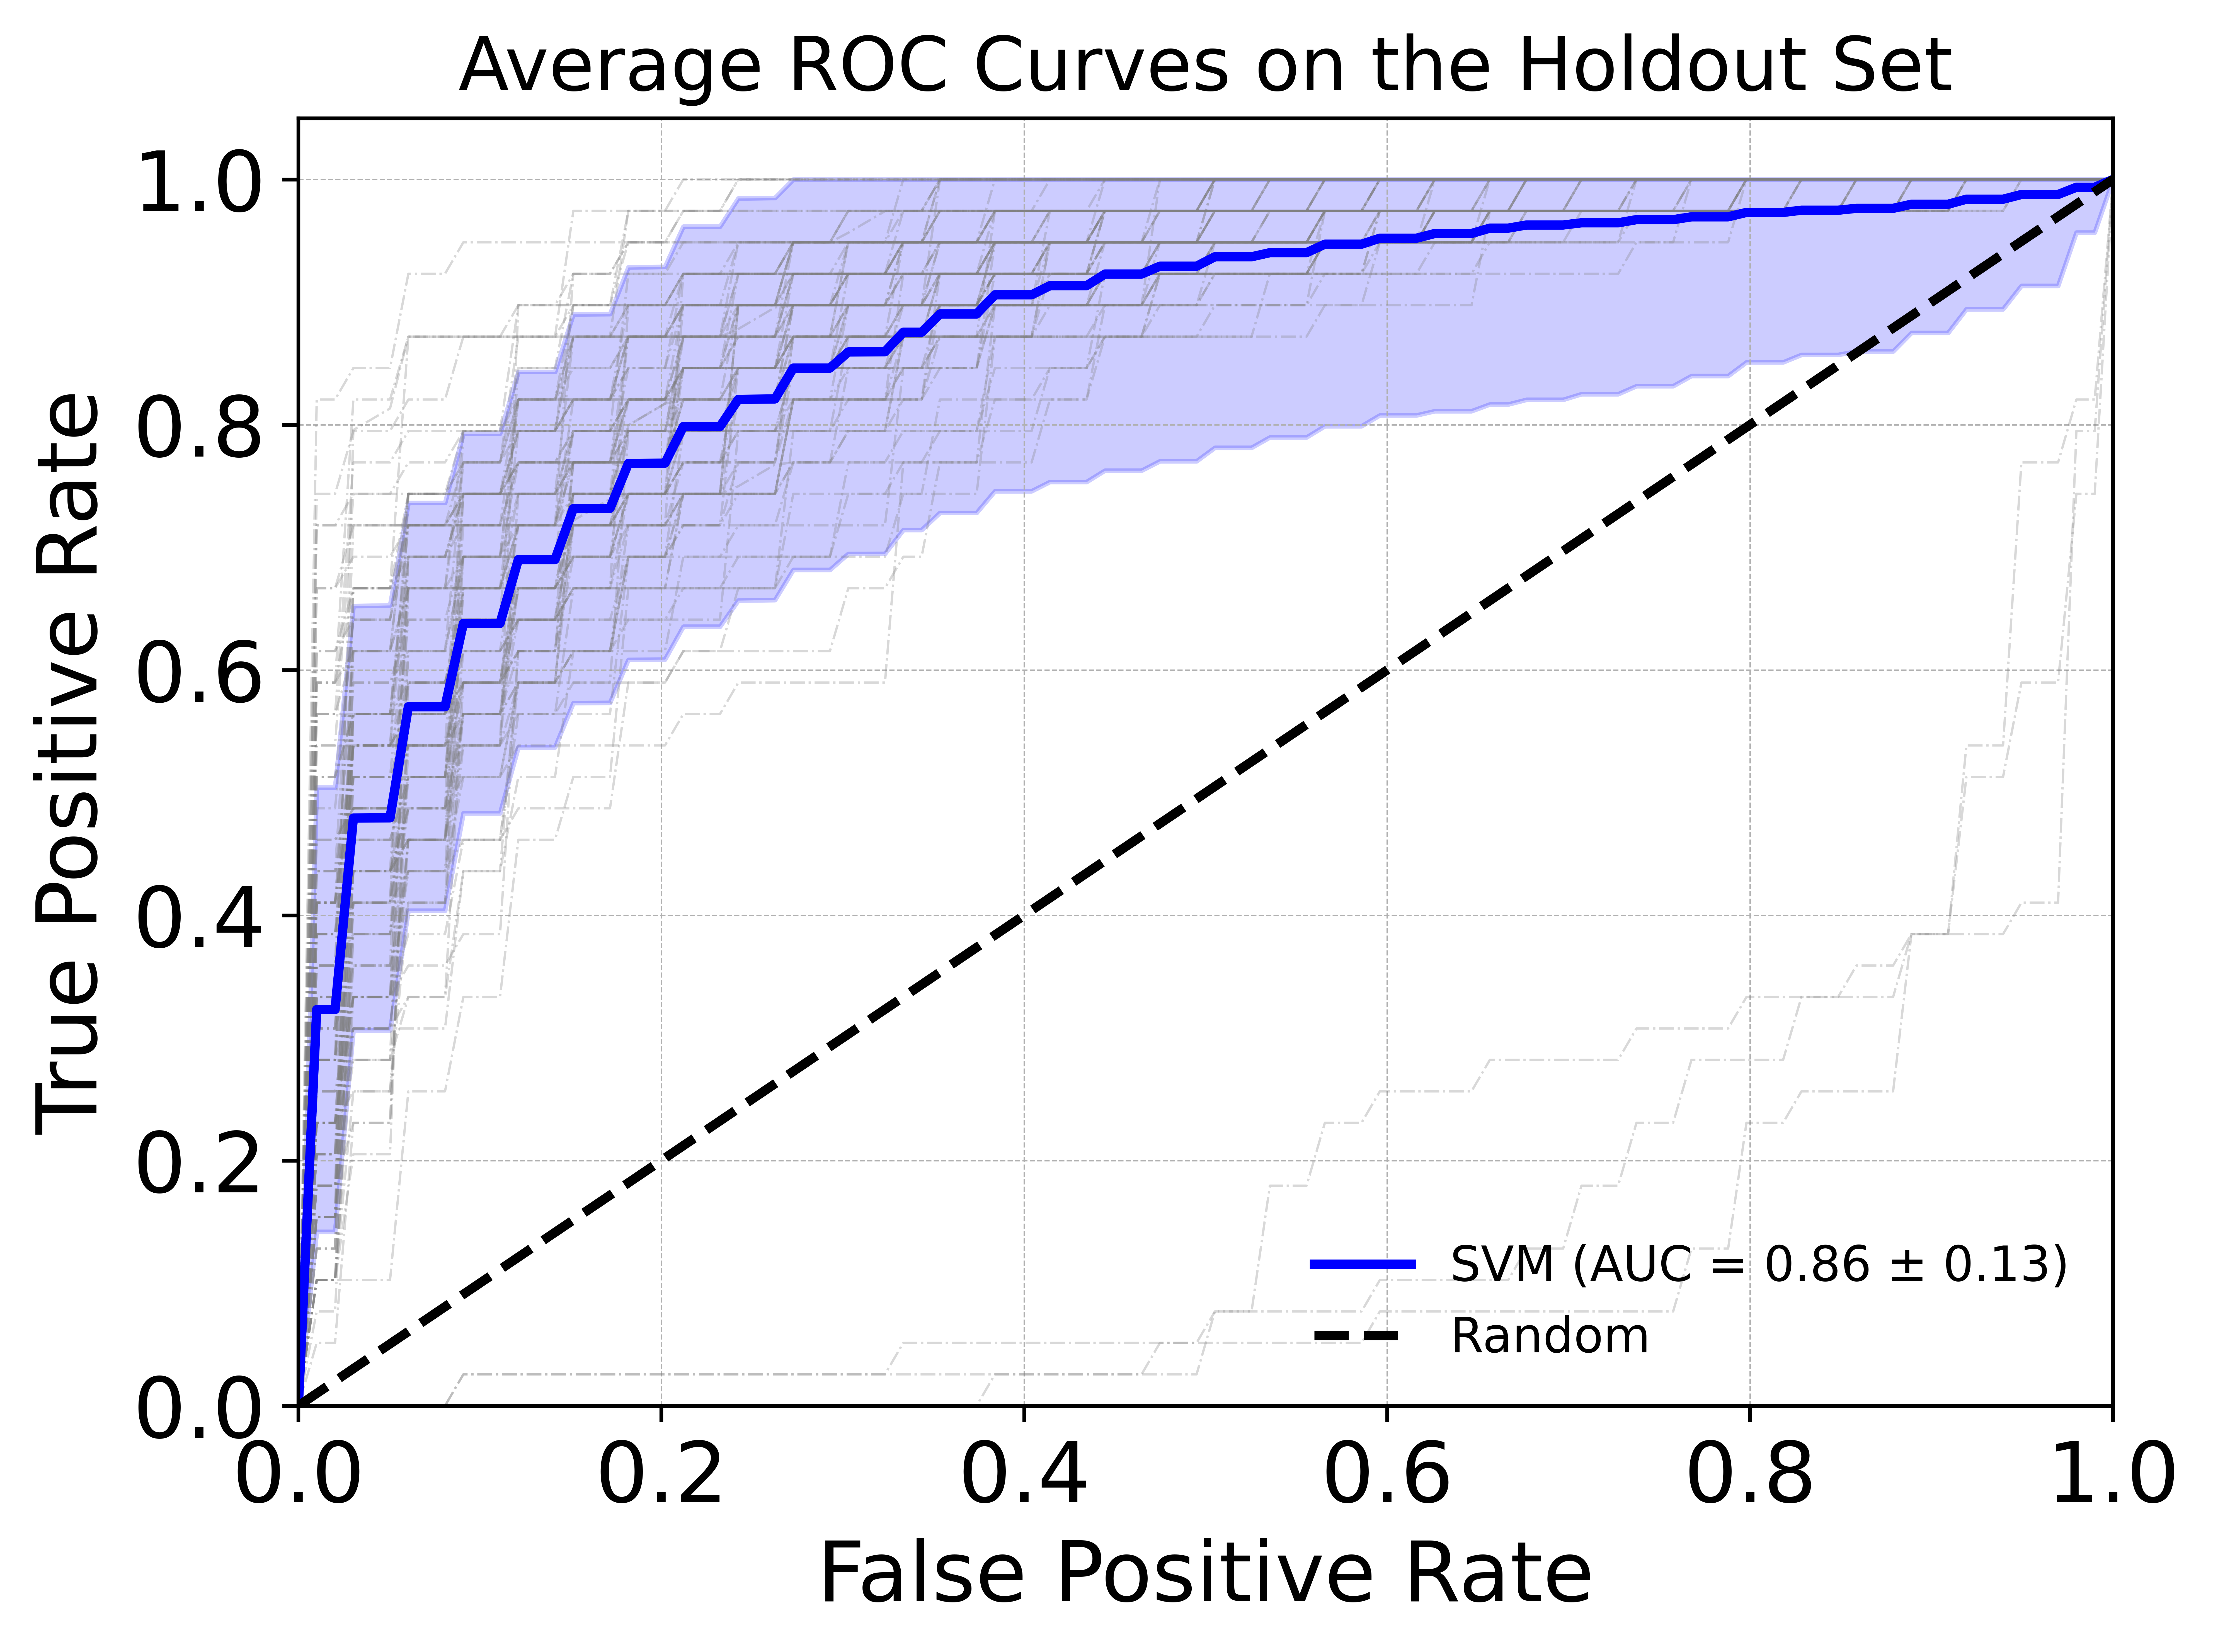

In [1]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
# ËØªÂèñ holdout ÁªìÊûú
with open('metrics/hold_metrics_list.pkl', 'rb') as f:
    hold_metrics_list = pickle.load(f)

# ËÆæÂÆöÁªòÂõæÂèÇÊï∞
plt.rcParams['figure.dpi'] = 1200
plt.rcParams.update({'font.size': 18})

# ËÆæÂÆöÊ®°ÂûãÂèÇÊï∞
model_name = ['SVM']
model_num = 1  # Âè™Êúâ SVM
epoch_num = 100 # Á°Æ‰øùËøôÈáåÁöÑ epoch_num ‰∏éÂÆûÈôÖËÆ≠ÁªÉÊ¨°Êï∞‰∏ÄËá¥
outer_num = 5
inner_num = 3

# ÂàùÂßãÂåñÂ≠òÂÇ® AUC Êï∞ÊçÆ
roc_data_holdout = {"SVM": {"fprs": [], "tprs": []}}

plt.figure(figsize=(7, 5))

# ËÆæÂÆöÊ®°Âûã‰ø°ÊÅØ
model_info = [{"name": "SVM", "color": "b"}]

# ËÆ°ÁÆó ROC Êõ≤Á∫ø
for model in model_info:
    base_fpr = np.linspace(0, 1, 100)
    tprs = []
    mean_tpr = np.zeros_like(base_fpr)
    
    # ÈÅøÂÖçË∂ÖÂá∫Á¥¢Âºï
    if len(hold_metrics_list) < epoch_num:
        print(f"‚ö†Ô∏è Ë≠¶ÂëäÔºöhold_metrics_list ÈïøÂ∫¶ {len(hold_metrics_list)} Â∞è‰∫é epoch_num {epoch_num}")
        epoch_num = len(hold_metrics_list)
    
    # ËÆ°ÁÆó AUC Âπ∂ÁªòÂà∂ÊØè‰∏™ epoch ÁöÑÊõ≤Á∫ø
    for i in range(epoch_num):
        if i >= len(hold_metrics_list):
            print(f"‚ö†Ô∏è Ë∑≥Ëøá epoch {i}ÔºåÂõ†‰∏∫ hold_metrics_list ËøáÁü≠")
            continue

        y_test_holdout, y_pred_prob_holdout = hold_metrics_list[i]
        fpr, tpr, _ = roc_curve(y_test_holdout, y_pred_prob_holdout)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        mean_tpr += tpr
        
        # ÁîªÂá∫ÊØè‰∏™ epoch ÁöÑ ROC Êõ≤Á∫ø
        plt.plot(base_fpr, tpr, color='gray', alpha=0.3, linewidth=0.5,  linestyle='-.')
    
    mean_tpr /= epoch_num
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    std_auc = np.std([auc(base_fpr, tpr) for tpr in tprs]) if tprs else 0
    std_tpr = np.std(tprs, axis=0) if tprs else np.zeros_like(base_fpr)
    
    # Â≠òÂÇ® AUC ËÆ°ÁÆóÊï∞ÊçÆ
    roc_data_holdout[model["name"]]["base_fpr"] = base_fpr
    roc_data_holdout[model["name"]]["mean_tpr"] = mean_tpr
    roc_data_holdout[model["name"]]["mean_auc"] = mean_auc
    roc_data_holdout[model["name"]]["std_auc"] = std_auc
    roc_data_holdout[model["name"]]["std_tpr"] = std_tpr

# ÁªòÂà∂Âπ≥Âùá ROC Êõ≤Á∫ø
for model in model_info:
    base_fpr = roc_data_holdout[model["name"]]["base_fpr"]
    mean_tpr = roc_data_holdout[model["name"]]["mean_tpr"]
    mean_auc = roc_data_holdout[model["name"]]["mean_auc"]
    std_auc = roc_data_holdout[model["name"]]["std_auc"]
    std_tpr = roc_data_holdout[model["name"]]["std_tpr"]
    
    plt.plot(
        base_fpr,
        mean_tpr,
        color=model["color"],
        label=f'{model["name"]} (AUC = {mean_auc:.2f} ¬± {std_auc:.2f})',
        linewidth=2
    )
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=model["color"], alpha=0.2)

# ÁªòÂõæËÆæÁΩÆ
plt.plot([0, 1], [0, 1], linestyle="--", color="k", lw=2, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curves on the Holdout Set", fontsize=16)
plt.legend(loc='lower right', fontsize='xx-small', ncol=1, frameon=False)
plt.grid(axis='both', linestyle='--', linewidth=0.3)

# Á°Æ‰øù image ÁõÆÂΩïÂ≠òÂú®
os.makedirs("image", exist_ok=True)

# ‰øùÂ≠òÂõæÂÉè
plt.savefig("image/hold_roc_curves.jpg", dpi=1200, bbox_inches='tight')
plt.show()

In [2]:
# Á°Æ‰øù epoch_num Ê≠£Á°Æ
epoch_num = min(100, len(hold_metrics_list))  # Á°Æ‰øù‰∏ç‰ºöË∂ÖÂá∫Á¥¢Âºï

# Â≠òÂÇ®ÂêÑ‰∏™ÊåáÊ†á
sensitivity_list = []
specificity_list = []
balanced_accuracy_list = []
auc_list = []

# ËÆ°ÁÆóÊØè‰∏™ Epoch ÁöÑÊåáÊ†á
for i in range(epoch_num):
    y_test_holdout, y_pred_prob_holdout = hold_metrics_list[i]


    # **‰ΩøÁî® 0.5 ÈòàÂÄºËÆ°ÁÆó‰∫åÂàÜÁ±ªÁªìÊûú**
    y_pred_binary = (y_pred_prob_holdout > 0.5).astype(int)

    # **ËÆ°ÁÆóÊ∑∑Ê∑ÜÁü©Èòµ**
    tn, fp, fn, tp = confusion_matrix(y_test_holdout, y_pred_binary).ravel()

    # **ËÆ°ÁÆó SensitivityÔºàÁÅµÊïèÂ∫¶Ôºâ**
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivity_list.append(sensitivity)

    # **ËÆ°ÁÆó SpecificityÔºàÁâπÂºÇÊÄßÔºâ**
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_list.append(specificity)

    # **ËÆ°ÁÆó Balanced AccuracyÔºàÂπ≥Ë°°ÂáÜÁ°ÆÁéáÔºâ**
    balanced_acc = balanced_accuracy_score(y_test_holdout, y_pred_binary)
    balanced_accuracy_list.append(balanced_acc)

# **ËÆ°ÁÆóÂùáÂÄºÂíåÊ†áÂáÜÂ∑Æ**
mean_sensitivity, std_sensitivity = np.mean(sensitivity_list), np.std(sensitivity_list)
mean_specificity, std_specificity = np.mean(specificity_list), np.std(specificity_list)
mean_balanced_acc, std_balanced_acc = np.mean(balanced_accuracy_list), np.std(balanced_accuracy_list)


# **ÊâìÂç∞ÁªìÊûú**
print("üîπ Holdout Test Results (Mean ¬± Std)")
print(f" Sensitivity (Recall) : {mean_sensitivity:.2f} ¬± {std_sensitivity:.2f}")
print(f" Specificity          : {mean_specificity:.2f} ¬± {std_specificity:.2f}")
print(f" Balanced Accuracy    : {mean_balanced_acc:.2f} ¬± {std_balanced_acc:.2f}")


üîπ Holdout Test Results (Mean ¬± Std)
 Sensitivity (Recall) : 0.82 ¬± 0.07
 Specificity          : 0.76 ¬± 0.15
 Balanced Accuracy    : 0.79 ¬± 0.07


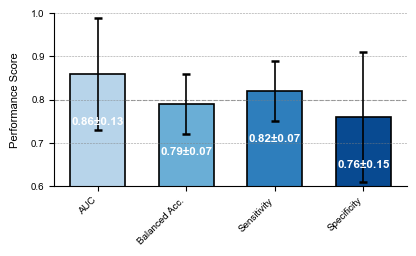

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import Blues

# ËÆæÁΩÆNatureÊúüÂàäÊõ¥‰∏•Ê†ºÁöÑÊ†∑ÂºèÂèÇÊï∞
plt.rcParams.update({
    'font.size': 7,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'font.sans-serif': 'Arial',
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.2,
    'legend.frameon': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Êï∞ÊçÆÂáÜÂ§á
metrics = {

    "AUC": (0.86, 0.13),
    "Balanced Acc.": (0.79, 0.07),
    "Sensitivity": (0.82, 0.07),
    "Specificity": (0.76, 0.15),
}
categories = list(metrics.keys())
means = [v[0] for v in metrics.values()]
stds = [v[1] for v in metrics.values()]

# ‰ΩøÁî®ÁßëÂ≠¶ÂåñÂçïËâ≤Ê∏êÂèò
color_vals = np.linspace(0.3, 0.9, len(categories))
colors = Blues(color_vals)

# ÂàõÂª∫ÁîªÂ∏ÉÔºàË∞ÉÊï¥ÂÆΩÈ´òÊØî‰∏∫ÈªÑÈáëÂàÜÂâ≤ÊØî‰æãÔºâ
fig, ax = plt.subplots(figsize=(4.2, 4.2*(5**0.5-1)/2))

# ÁªòÂà∂Êü±Áä∂ÂõæÔºàË∞ÉÊï¥ËØØÂ∑ÆÊù°ÂèÇÊï∞Ôºâ
bars = ax.bar(categories, means, 
             color=colors,
             edgecolor='k',
             linewidth=1.2,
             width=.62,
             yerr=stds,
             error_kw={'elinewidth': 1.2, 'capsize':3, 'capthick':1.8})

# ‰ºòÂåñÊï∞ÂÄºÊ†áÊ≥®
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean - 0.06,  # Â∞ÜÊ†áÁ≠æÁßªËá≥Êü±‰ΩìÂÜÖÈÉ®
            f"\n\n{mean:.2f}¬±{std:.2f}", 
            ha='center', va='top',
            color='white',  # Â¢ûÂº∫ÂØπÊØîÂ∫¶
            fontsize=8.5,
            fontweight='bold',
            linespacing=0.8)

# ÂùêÊ†áËΩ¥‰ºòÂåñ
ax.set_ylim(0.6, 1.0)  # ËÅöÁÑ¶Êï∞ÊçÆËåÉÂõ¥
ax.set_yticks(np.arange(0.6, 1.01, 0.1))
ax.set_ylabel("Performance Score", labelpad=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ê∑ªÂä†Âü∫ÂáÜÂèÇËÄÉÁ∫ø
ax.axhline(0.8, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, zorder=0)

# ‰ºòÂåñÁΩëÊ†ºÁ∫ø
ax.grid(True, axis='y', 
        color='grey', 
        linestyle='--', 
        linewidth=0.4, 
        alpha=0.8)

# Ë∞ÉÊï¥XËΩ¥Ê†áÁ≠æËßíÂ∫¶Èò≤Ê≠¢ÈáçÂè†
plt.xticks(rotation=45, ha='right')

# ‰ºòÂåñÂ∏ÉÂ±Ä
plt.tight_layout(pad=1.2)

# ‰øùÂ≠ò‰∏∫Á¨¶ÂêàNatureË¶ÅÊ±ÇÁöÑTIFFÊ†ºÂºè
plt.savefig("optimized_mean_std.jpg", 
           dpi=1200, 
   
           pil_kwargs={"compression": "tiff_lzw"})

plt.show()

In [3]:
print("ÂÖ®ÈÉ®ÂÆåÊàêÔºÅÔºÅ")

ÂÖ®ÈÉ®ÂÆåÊàêÔºÅÔºÅ
